In [ ]:
!pip install imbalanced-learn

In [2]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import re

from imblearn.over_sampling import SMOTE
from collections import Counter
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm_notebook as tqdm
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
!python -m spacy download ru_core_news_lg

This time we will classify russian texts so it's important to lemmatize them. <br>For this i will use spacy library


In [4]:
nlp = spacy.load("ru_core_news_lg")
nlp.disable_pipes('ner', 'parser', 'attribute_ruler')
nlp.add_pipe('sentencizer')
print(nlp.pipe_names)

['tok2vec', 'morphologizer', 'lemmatizer', 'sentencizer']


This is a simple text tonal classification

In [5]:
df = pd.read_csv('Rzd_official_labeled.csv', sep=';', encoding='utf8')
df

,Column1,date,text,label
0,0.0,31.12.2019,Почему закрыта тема с отзывами? Российские жел...,negative
1,1.0,31.12.2019,"Хочу выразить благодарность проводнице Ольге, ...",positive
2,2.0,02.01.2020,"хорошая техподдержка, ответы развёрнутые.",positive
3,3.0,03.01.2020,Очень понравилось на поезде было 30.12.2019,positive
4,4.0,04.01.2020,"К сожалению, у меня сложное аутоиммунное забол...",negative
...,...,...,...,...
785,784.0,28.12.2021,РЖД какими вы были такими и остались ! ехали п...,negative
786,785.0,29.12.2021,Как можно разрешить провозить животных в купе ...,negative
787,786.0,30.12.2021,"Добрый день, всегда уезжаем с Курского вокзала...",negative
788,787.0,31.12.2021,"Не очень люблю поезда, особенно плацкарт , но ...",positive


In [6]:
df['label'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

In [7]:
labels = {'negative': 0, 'neutral' : 1, 'positive': 2}
enc = LabelEncoder()
df['label'] = enc.fit_transform(df['label'])
df = df.drop('Column1', axis=1)
df = df.drop('date', axis=1)
df

,text,label
0,Почему закрыта тема с отзывами? Российские жел...,0
1,"Хочу выразить благодарность проводнице Ольге, ...",2
2,"хорошая техподдержка, ответы развёрнутые.",2
3,Очень понравилось на поезде было 30.12.2019,2
4,"К сожалению, у меня сложное аутоиммунное забол...",0
...,...,...
785,РЖД какими вы были такими и остались ! ехали п...,0
786,Как можно разрешить провозить животных в купе ...,0
787,"Добрый день, всегда уезжаем с Курского вокзала...",0
788,"Не очень люблю поезда, особенно плацкарт , но ...",2


This time we can get rid of not only stop words but also of any word that doesn't have significant meaning in text.<br> I decided to use only verbs, nouns, adjectives and adverbs

In [8]:
all_words = [] # list for all words in all texts
for row_index, row in tqdm(df.iterrows()):

  text = row['text']
  clear = re.findall('[а-я]+', text.lower()) # all words in one text

  for i, word in enumerate(clear):
    word_processed = nlp(word)[0]
    if word_processed.pos_ not in ['VERB', 'NOUN', 'ADJ', 'ADV']:
      clear.remove(word)
    else:
      clear[i] = word_processed.lemma_

  all_words.extend(clear)
      
  clear = ' '.join(clear)
  df.loc[row_index, 'text'] = clear

<ipython-input-8-e625a7d03d7c>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row_index, row in tqdm(df.iterrows()):


0it [00:00, ?it/s]

In [9]:
word_count = Counter(all_words)
len(word_count)

8001

In [10]:
all_words = [i[0] for i in word_count.most_common(500)]

This time I will use one hot encoding and mean text embedding vector

In [11]:
def get_embeddings(doc):
    text_embeddings = []
    for sent in doc.sents:
        sent_embeddings = []
        for token in sent:
              sent_embeddings.append(token.vector)
        text_embeddings.append(np.mean(sent_embeddings, axis=0))
    text_embeddings = np.mean(text_embeddings, axis=0)
    if np.isnan(text_embeddings[0]):
        text_embeddings = [0 for _ in range(300)]
    return text_embeddings

In [12]:
columns = ['target']
columns.extend(all_words)
for i in range(300):
    columns.append('emb'+ str(i))
score_df = pd.DataFrame(columns = columns)
for row in tqdm(df.iterrows()):
    text = row[1]['text']
    doc = nlp(text)
    lemmas = [i.lemma_ for i in doc if i.pos_ in ['VERB', 'NOUN', 'ADV', 'ADJ']]
    embedding = get_embeddings(doc)
    one_hot_text = [1 if i in lemmas else 0 for i in all_words]
    numeric = [row[1]['label']]
    numeric.extend(one_hot_text)
    numeric.extend(embedding)
    score_df.loc[len(score_df)] = numeric

score_df

<ipython-input-12-221edbea899a>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row in tqdm(df.iterrows()):


0it [00:00, ?it/s]

,target,поезд,вагон,проводник,благодарность,очень,спасибо,хотеть,не,в,...,emb290,emb291,emb292,emb293,emb294,emb295,emb296,emb297,emb298,emb299
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.046293,-0.094585,-0.060675,-0.055240,0.044505,-0.199965,-0.035849,-0.188020,-0.019136,0.085002
1,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.041505,0.000172,-0.003579,0.037415,0.020476,-0.242183,-0.087631,-0.252549,-0.112141,0.155302
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.018695,0.035979,0.014072,0.185444,0.085146,-0.171517,-0.039567,-0.111265,-0.070034,0.120835
3,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.168371,-0.030380,0.173095,0.079510,0.072834,-0.106007,-0.105059,-0.023677,0.091557,0.194914
4,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.003861,-0.043366,-0.086095,0.023390,0.104285,-0.209324,-0.008774,-0.192556,-0.067579,0.148934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.181041,-0.122644,-0.035411,-0.065974,0.026523,-0.126840,-0.110005,-0.301810,0.047933,0.124252
786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.028848,0.011739,-0.019917,0.021451,0.030988,-0.140008,-0.129000,-0.185136,-0.164137,0.114840
787,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.008558,0.014000,-0.033029,0.020796,0.119113,-0.127923,-0.056526,-0.203359,-0.021196,0.144174
788,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.015774,-0.044644,-0.000763,0.036157,0.180875,-0.201974,-0.049862,-0.201598,-0.036821,0.136691


In [13]:
label = score_df['target']
data = score_df.drop(columns=['target'])
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.2, random_state=42)
Counter(label)

Counter({0.0: 315, 2.0: 420, 1.0: 55})

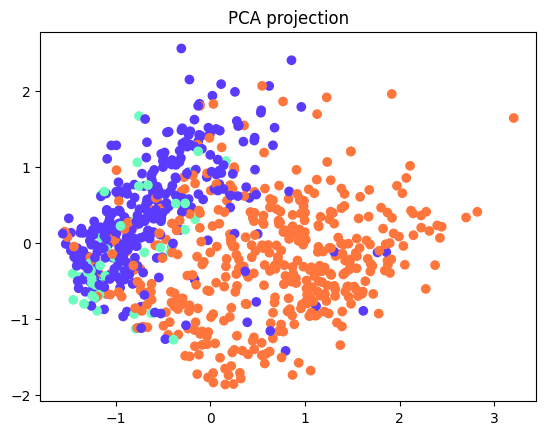

In [14]:
pca = PCA(n_components=2)
d2 = pca.fit_transform(data)
color_palette = sns.color_palette('rainbow', 12)

plt.scatter(
    d2[:, 0],
    d2[:, 1],
    c= [color_palette[int(x) * 5] for x in label])
plt.title('PCA projection', fontsize=12)
plt.show()

This dataset is very imbalanced so i decided to use oversample

---
**NOTE: I only oversample the train part!**

---


If you try to oversample the whole dataset you will ruin tests result. It will no longer be test on the real data but on the fake one

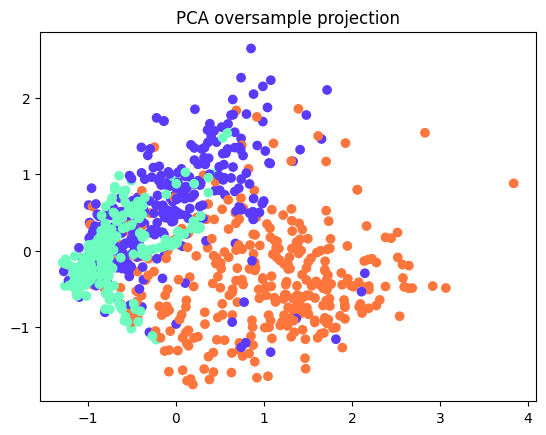

In [15]:
oversample = SMOTE()
oversample_x, oversample_y = oversample.fit_resample(train_x, train_y)

pca = PCA(n_components=2)
d2 = pca.fit_transform(oversample_x)
color_palette = sns.color_palette('rainbow', 12)

plt.scatter(
    d2[:, 0],
    d2[:, 1],
    c= [color_palette[int(x) * 5] for x in oversample_y])
plt.title('PCA oversample projection', fontsize=12)
plt.show()

## Classification

Let's try to use both one hot vector and embedding vector at once

In [16]:
def get_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(train_x.shape[1]))
  model.add(tf.keras.layers.Dense(128, activation = 'relu'))
  model.add(tf.keras.layers.Dense(64, activation = 'relu'))
  model.add(tf.keras.layers.Dropout(.2))
  model.add(tf.keras.layers.Dense(3, activation = 'softmax'))
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
  return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               102528    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 110,979
Trainable params: 110,979
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(train_x, train_y, epochs=5, batch_size=32)

Epoch 1/5
20/20 [==============================] - 1s 4ms/step - loss: 0.8729 - accuracy: 0.5506
Epoch 2/5
20/20 [==============================] - 0s 3ms/step - loss: 0.5437 - accuracy: 0.8386
Epoch 3/5
20/20 [==============================] - 0s 4ms/step - loss: 0.4143 - accuracy: 0.8592
Epoch 4/5
20/20 [==============================] - 0s 3ms/step - loss: 0.3474 - accuracy: 0.8829
Epoch 5/5
20/20 [==============================] - 0s 3ms/step - loss: 0.2722 - accuracy: 0.9051


In [18]:
pred_y = model.predict(test_x)
prediction = np.argmax(pred_y, axis=1)

5/5 [==============================] - 0s 2ms/step


In [19]:
print(classification_report(test_y, prediction))

              precision    recall  f1-score   support

         0.0       0.73      0.84      0.78        61
         1.0       1.00      0.07      0.12        15
         2.0       0.87      0.93      0.90        82

    accuracy                           0.81       158
   macro avg       0.87      0.61      0.60       158
weighted avg       0.83      0.81      0.78       158



<Axes: >

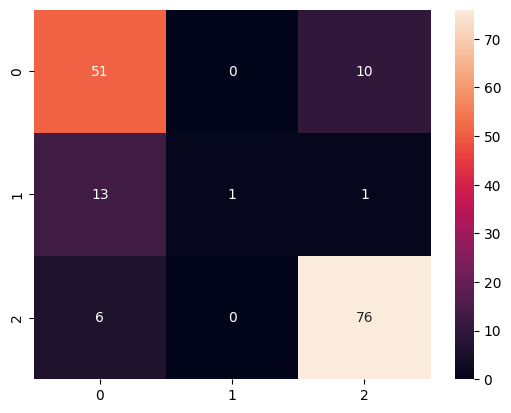

In [20]:
sns.heatmap(confusion_matrix(test_y, prediction), annot=True)

In [35]:
model = get_model()
model.fit(oversample_x, oversample_y, epochs=5, batch_size=32)

Epoch 1/5
32/32 [==============================] - 2s 7ms/step - loss: 0.7950 - accuracy: 0.7150
Epoch 2/5
32/32 [==============================] - 0s 4ms/step - loss: 0.3776 - accuracy: 0.8659
Epoch 3/5
32/32 [==============================] - 0s 5ms/step - loss: 0.2030 - accuracy: 0.9458
Epoch 4/5
32/32 [==============================] - 0s 8ms/step - loss: 0.1164 - accuracy: 0.9714
Epoch 5/5
32/32 [==============================] - 0s 6ms/step - loss: 0.0683 - accuracy: 0.9872


In [36]:
pred_y = model.predict(test_x)
prediction = np.argmax(pred_y, axis=1)

5/5 [==============================] - 0s 3ms/step


In [37]:
print(classification_report(test_y, prediction))

              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76        61
         1.0       0.67      0.27      0.38        15
         2.0       0.83      0.93      0.87        82

    accuracy                           0.80       158
   macro avg       0.75      0.65      0.67       158
weighted avg       0.79      0.80      0.78       158



As you can see, training with oversampled dataset increase F1 macro score by .07

<Axes: >

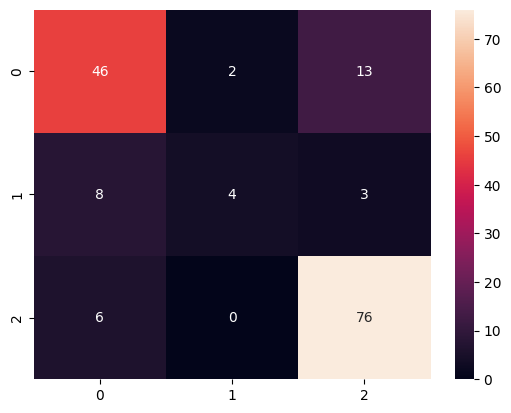

In [38]:
sns.heatmap(confusion_matrix(test_y, prediction), annot=True)

## Functional API

This time I'm gonna use model with 2 separate input layers. <br>One will be for the one hot vector and the other one for the embeddings

In [51]:
embedding_start_index = 300
train_emb = oversample_x.iloc[:,embedding_start_index:]
train_oh = oversample_x.iloc[:,:embedding_start_index]
test_emb = test_x.iloc[:,embedding_start_index:]
test_oh = test_x.iloc[:,:embedding_start_index]

In [52]:
test_emb.shape, train_oh.shape

((158, 500), (1014, 300))

In [53]:
one_hot_in = tf.keras.Input(shape=(train_oh.shape[1],), name='one_hot')
one_hot_hidden = keras.layers.Dense(64, name='one_hot_hidden')(one_hot_in)

embeddings_in = keras.Input(shape=(train_emb.shape[1],), name='embedding')
embeddings_hidden = keras.layers.Dense(64, name='embeddings_hidden')(embeddings_in)


conc = keras.layers.concatenate([embeddings_hidden, one_hot_hidden], name='conc')
conc_hidden = keras.layers.Dense(64, name='all_hidden')(conc)
conc_dropout = keras.layers.Dropout(.2, name='dropout')(conc_hidden)
final = keras.layers.Dense(3, name='out', activation = 'softmax')(conc_dropout)

model_v2 = keras.Model(
    inputs=[one_hot_in, embeddings_in],
    outputs=[final],
)
model_v2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding (InputLayer)         [(None, 500)]        0           []                               
                                                                                                  
 one_hot (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embeddings_hidden (Dense)      (None, 64)           32064       ['embedding[0][0]']              
                                                                                                  
 one_hot_hidden (Dense)         (None, 64)           19264       ['one_hot[0][0]']                
                                                                                            

In [54]:
model_v2.compile(
    optimizer= 'adam',
    loss=[
        keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    ],
    metrics = ['accuracy']
)

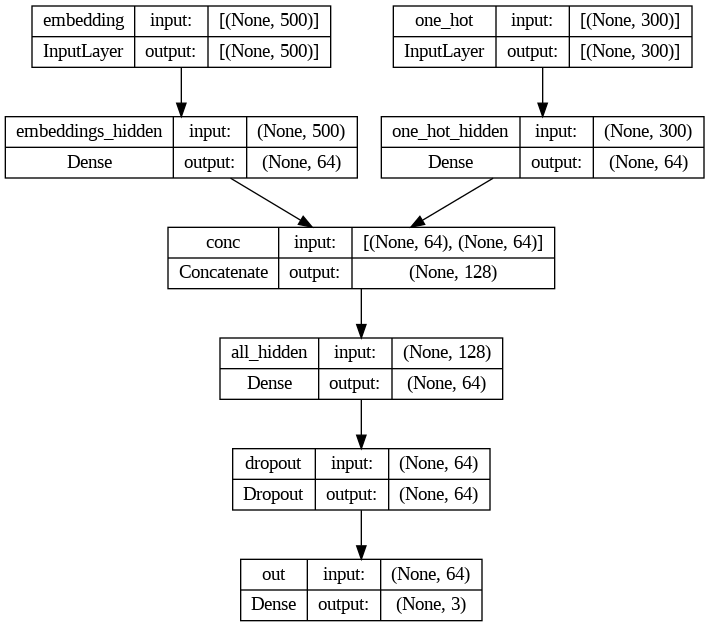

In [55]:
keras.utils.plot_model(model_v2, show_shapes=True)

In [56]:
model_v2.fit({'one_hot': train_oh, 'embedding': train_emb}, {'out': oversample_y}, epochs=5)

Epoch 1/5


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


32/32 [==============================] - 1s 2ms/step - loss: 0.7601 - accuracy: 0.6963
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 0.4124 - accuracy: 0.8550
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2716 - accuracy: 0.9231
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.1798 - accuracy: 0.9497
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.1230 - accuracy: 0.9665


In [57]:
res = model_v2.predict({'one_hot': test_oh, 'embedding': test_emb})
for i, el in enumerate(res):
    res[i] = np.argmax(el)
res = res[:,0]

5/5 [==============================] - 0s 2ms/step


<Axes: >

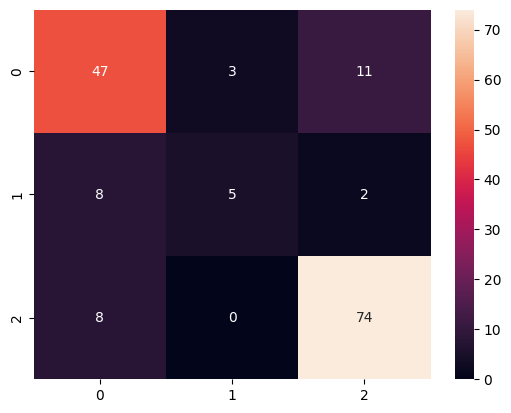

In [58]:
sns.heatmap(confusion_matrix(test_y, res), annot=True)

In [59]:
print(classification_report(test_y, res)) # functional API (60K params)

              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76        61
         1.0       0.62      0.33      0.43        15
         2.0       0.85      0.90      0.88        82

    accuracy                           0.80       158
   macro avg       0.74      0.67      0.69       158
weighted avg       0.79      0.80      0.79       158



In [60]:
print(classification_report(test_y, prediction)) # sequential (111K params)

              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76        61
         1.0       0.67      0.27      0.38        15
         2.0       0.83      0.93      0.87        82

    accuracy                           0.80       158
   macro avg       0.75      0.65      0.67       158
weighted avg       0.79      0.80      0.78       158



I managed to significantly decrease number of parameters in classifier and increase its results